In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
tf.compat.v1.disable_v2_behavior
from tensorflow import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'sklearn'

In [2]:
data = os.path.join('D:\Machine learning\data_sets\ham10000')

In [3]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data, '*.jpg'))}

In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
metadata = os.path.join('D:\Machine learning\data_sets\ham10000\csv')
skin_df = pd.read_csv(os.path.join(metadata, 'HAM10000_metadata.csv'))
skin_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


In [6]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9725,HAM_0004376,ISIC_0024843,akiec,histo,70.0,female,face,D:\Machine learning\data_sets\ham10000\ISIC_00...,Actinic keratoses,0
6059,HAM_0003024,ISIC_0024768,nv,follow_up,35.0,female,trunk,D:\Machine learning\data_sets\ham10000\ISIC_00...,Melanocytic nevi,4
4540,HAM_0001659,ISIC_0026564,nv,follow_up,35.0,male,lower extremity,D:\Machine learning\data_sets\ham10000\ISIC_00...,Melanocytic nevi,4
3817,HAM_0004625,ISIC_0029346,nv,follow_up,40.0,male,upper extremity,D:\Machine learning\data_sets\ham10000\ISIC_00...,Melanocytic nevi,4
7914,HAM_0000443,ISIC_0034271,nv,histo,35.0,female,back,D:\Machine learning\data_sets\ham10000\ISIC_00...,Melanocytic nevi,4


In [7]:
skin_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0031828,nv,histo,male,back,D:\Machine learning\data_sets\ham10000\ISIC_00...,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


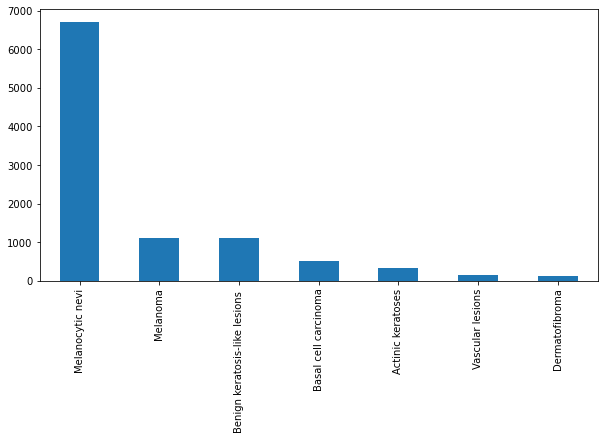

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [9]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

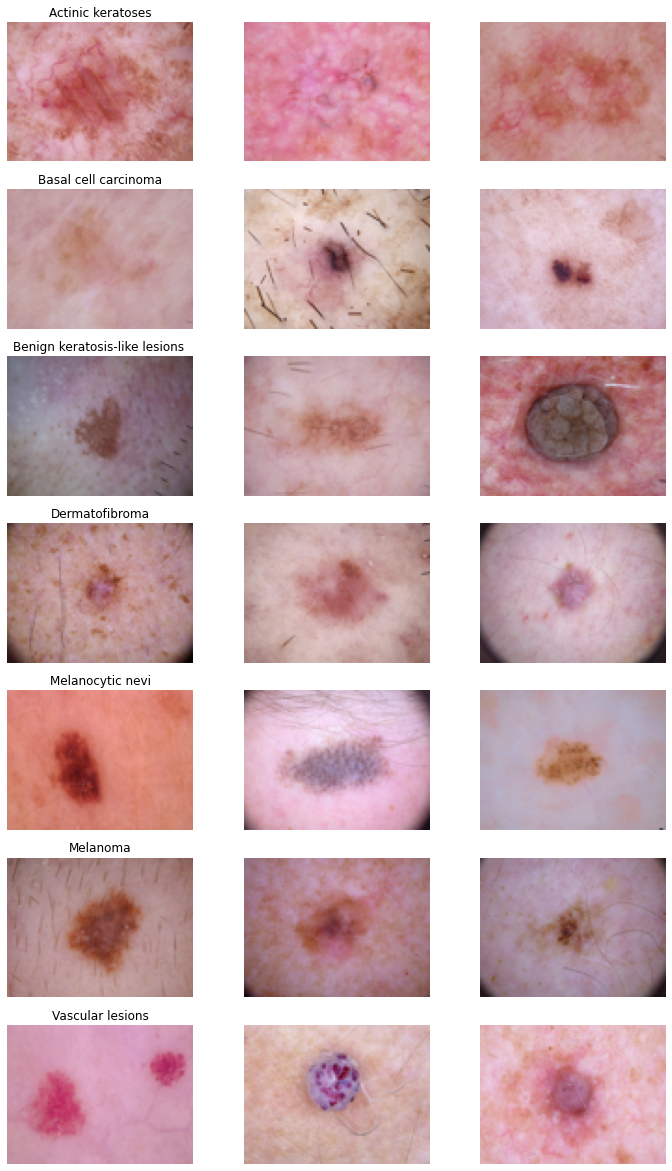

In [10]:
#Image Sampling
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [11]:
#Organizing dataset - input and output
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [12]:
#Traing and testing sampling
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20)

In [13]:
#Normalization - the x_train, x_test by substracting from theor mean values and then dividing by thier standard deviation.
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validate sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [14]:
from tensorflow.keras.layers import AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [15]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

##############################
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 32)       896       
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 100, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 100, 32)       128       
_________________________________________________________________
average_pooling2d (AveragePo (None, 37, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 64)        1

In [16]:
from tensorflow.keras.optimizers import Adam, SGD
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = SGD(lr=0.001, momentum=15, decay=0.0, nesterov=False)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
# data augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

In [18]:
datagen.fit(x_train)

In [19]:
## Fit the model
epochs = 100
batch_size = 20
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate))

  ...
    to  
  ['...']
Train for 361 steps, validate on 802 samples
Epoch 1/100
361/361 [==============================] - 23s 64ms/step - loss: 1.3123 - accuracy: 0.5724 - val_loss: 0.9129 - val_accuracy: 0.6683
Epoch 2/100
361/361 [==============================] - 15s 41ms/step - loss: 0.9499 - accuracy: 0.6714 - val_loss: 0.8956 - val_accuracy: 0.6858
Epoch 3/100
361/361 [==============================] - 14s 40ms/step - loss: 0.8847 - accuracy: 0.6911 - val_loss: 0.8547 - val_accuracy: 0.6933
Epoch 4/100
361/361 [==============================] - 15s 41ms/step - loss: 0.8445 - accuracy: 0.6981 - val_loss: 0.8514 - val_accuracy: 0.6995
Epoch 5/100
361/361 [==============================] - 15s 40ms/step - loss: 0.8245 - accuracy: 0.7074 - val_loss: 0.7732 - val_accuracy: 0.7157
Epoch 6/100
361/361 [==============================] - 15s 41ms/step - loss: 0.8118 - accuracy: 0.7069 - val_loss: 0.8008 - val_accuracy: 0.6983
Epoch 7/100
361/361 [==============================] - 15s 4

In [20]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Validation: accuracy = 0.754364  ;  loss_v = 0.885231
Test: accuracy = 0.775836  ;  loss = 0.770481


In [21]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification report for classifier <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002772E67CC48>:
              precision    recall  f1-score   support

     class 0       0.44      0.14      0.22        28
     class 1       0.69      0.50      0.58        48
     class 2       0.48      0.46      0.47        93
     class 3       0.20      0.12      0.15         8
     class 4       0.85      0.93      0.89       534
     class 5       0.48      0.34      0.40        82
     class 6       0.35      0.89      0.50         9

    accuracy                           0.75       802
   macro avg       0.50      0.48      0.46       802
weighted avg       0.74      0.75      0.74       802




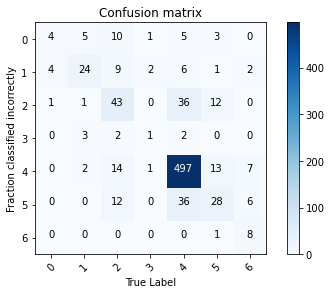

In [22]:
from sklearn import metrics
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

In [26]:
from tensorflow.compat.v1.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

input_shape = (75, 100, 3)

num_labels = 7

base_model = InceptionV3(include_top = False, input_shape = input_shape,pooling = 'avg', 
                         weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 903       
Total params: 22,065,959
Trainable params: 22,031,527
Non-trainable params: 34,432
_________________________________________________________________


In [27]:
optimizer = Adam (lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=5e-7, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [32]:
y_train = np.argmax(y_train, axis = 1)

In [38]:
y_validate = np.argmax(y_validate, axis = 1)

In [41]:
epochs = 12 
batch_size = 20
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

  ...
    to  
  ['...']
Train for 360 steps, validate on 802 samples
Epoch 1/12
360/360 [==============================] - 69s 193ms/step - loss: 1.2963 - accuracy: 0.7149 - val_loss: 0.9704 - val_accuracy: 0.7332
Epoch 2/12
360/360 [==============================] - 48s 134ms/step - loss: 1.0061 - accuracy: 0.7293 - val_loss: 1.2015 - val_accuracy: 0.7032
Epoch 3/12
360/360 [==============================] - 44s 123ms/step - loss: 0.8888 - accuracy: 0.7380 - val_loss: 10.6610 - val_accuracy: 0.6820
Epoch 4/12
360/360 [==============================] - 47s 132ms/step - loss: 0.8929 - accuracy: 0.7369 - val_loss: 1.0345 - val_accuracy: 0.7431
Epoch 5/12
360/360 [==============================] - 45s 126ms/step - loss: 0.8739 - accuracy: 0.7352 - val_loss: 0.9438 - val_accuracy: 0.6933
Epoch 6/12
360/360 [==============================] - 46s 127ms/step - loss: 0.8782 - accuracy: 0.7387 - val_loss: 3.6913 - val_accuracy: 0.7319
Epoch 7/12
360/360 [==============================] - 47s 1

In [43]:
y_test = np.argmax(y_test, axis = 1)

In [44]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Validation: accuracy = 0.687032  ;  loss_v = 0.917253
Test: accuracy = 0.703944  ;  loss = 0.895560


In [45]:
from tensorflow.keras.applications.xception import Xception

input_shape = (75, 100, 3)

num_labels = 7

base_model = Xception(include_top = False, input_shape = input_shape,pooling = 'avg', 
                         weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model.summary()

83689472/83683744 [==============================] - 2847s 34us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 903       
Total params: 21,124,655
Trainable params: 21,070,127
Non-trainable params: 54,528
_________________________________________________________________


In [46]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [56]:
#Traing and testing sampling
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validate sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [57]:
epochs =  35
batch_size = 20
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_steps=(x_validate.shape[0] // batch_size),
                    callbacks=[learning_rate_reduction])

  ...
    to  
  ['...']
Train for 360 steps, validate on 802 samples
Epoch 1/35
360/360 [==============================] - 161s 446ms/step - loss: 4.5612 - acc: 0.6734 - val_loss: 3.1023 - val_acc: 0.7287
Epoch 2/35
360/360 [==============================] - 62s 173ms/step - loss: 2.3906 - acc: 0.7389 - val_loss: 1.8603 - val_acc: 0.7725
Epoch 3/35
360/360 [==============================] - 62s 173ms/step - loss: 1.5039 - acc: 0.7636 - val_loss: 1.2380 - val_acc: 0.8025
Epoch 4/35
360/360 [==============================] - 62s 173ms/step - loss: 1.0802 - acc: 0.7992 - val_loss: 0.9744 - val_acc: 0.8138
Epoch 5/35
360/360 [==============================] - 62s 173ms/step - loss: 0.8705 - acc: 0.8164 - val_loss: 0.8347 - val_acc: 0.8200
Epoch 6/35
360/360 [==============================] - 62s 173ms/step - loss: 0.7305 - acc: 0.8295 - val_loss: 0.8065 - val_acc: 0.8175
Epoch 7/35
360/360 [==============================] - 63s 174ms/step - loss: 0.6417 - acc: 0.8491 - val_loss: 0.7578 - 

In [58]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

802/802 [==============================] - 3s 3ms/sample - loss: 0.8042 - acc: 0.8329
Validation: accuracy = 0.832918  ;  loss_v = 0.804246
Test: accuracy = 0.826760  ;  loss = 0.809721


In [59]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification report for classifier <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002790FEC5108>:
              precision    recall  f1-score   support

     class 0       0.59      0.42      0.49        24
     class 1       0.82      0.70      0.76        47
     class 2       0.58      0.72      0.64        79
     class 3       0.82      0.75      0.78        12
     class 4       0.92      0.93      0.92       549
     class 5       0.59      0.49      0.54        81
     class 6       0.80      0.80      0.80        10

    accuracy                           0.83       802
   macro avg       0.73      0.69      0.70       802
weighted avg       0.83      0.83      0.83       802




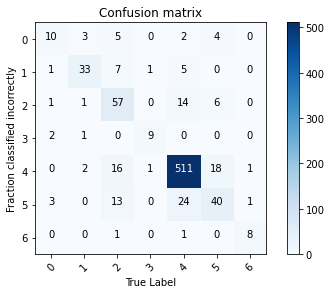

In [60]:
from sklearn import metrics
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

In [61]:
model.save('Xception.h5')

Text(0.5, 1.0, 'Training and validation loss')

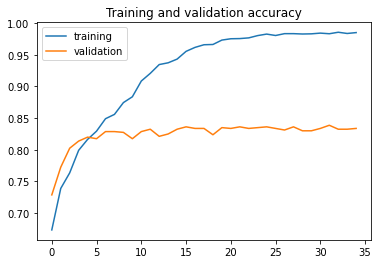

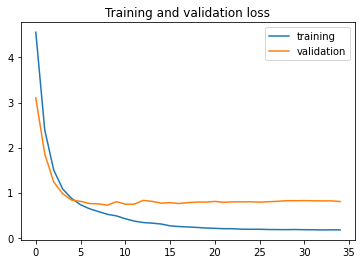

In [62]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [64]:
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_validate.npy', x_validate)
np.save('y_validate.npy', x_validate)
np.save('x_test.npy', x_test)
np.save('y_test.npy', x_test)